In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

pt.set_default_tensor_type('torch.FloatTensor')
#pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
from princo_ml.controllers import Controller as Control
from princo_ml.clusters import DataCluster as Data, LearnCluster as Learn, MergeCluster as Merge
from princo_ml.utils.learn_modules.learners import GradientLearner, NewtonLearner, MomentumLearner, SmoothLearner
from princo_ml.utils.learn_modules.activators import LinearActivator, SigmoidActivator, TanhActivator, ReluActivator
from princo_ml.utils.learn_modules import DenseHingeModule

In [3]:
dataset = pd.read_csv(
    'data_files/kc_house_data.csv',
    index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')
)
dataset = dataset[[col for col in dataset.columns if not col.endswith('15')]]
feature_cols = ['sqft_living', 'bedrooms', 'bathrooms']
target_cols = ['price']

<ipython-input-3-87e43fa885c5>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')


In [4]:
verbose = False

learner = SmoothLearner

learn_rate_kwargs = {
    'seed_learn': 5e-1
}

loss_kwargs = {}

nesterov = True

hinger = DenseHingeModule
hinges = 5

activator = TanhActivator
activator_kwargs = {
    #'leak': 0.1
}

batcher_kwargs = {
    'proportion': 1.0
}

control = Control(
    'regression_controller',
    loss_smooth_coefs = [0.9, 100]
)

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter_kwargs = {'verbose': verbose},
        batcher_kwargs = {'verbose': verbose, **batcher_kwargs},
        loss_kwargs = {'verbose': verbose, **loss_kwargs},
        loss_combiner_kwargs = {'verbose': verbose},
        verbose = verbose
    )
)

control.link_add(
    Learn(
        'learn_cluster_1',
        module = hinger,
        module_kwargs = {
            'nodes': 128,
            'hinges': hinges,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_add(
    Learn(
        'learn_cluster_2',
        module_kwargs = {
            'nodes': 32,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_1', 'input'
)

control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs = {
            'nodes': len(target_cols),
            'verbose': verbose,
            'nesterov': nesterov,
            'learner': learner,
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_2', 'input'
    #'data_cluster', 'input', data_cols = feature_cols
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols = target_cols)

control.enable_network()

In [5]:
control.train_model(1000)

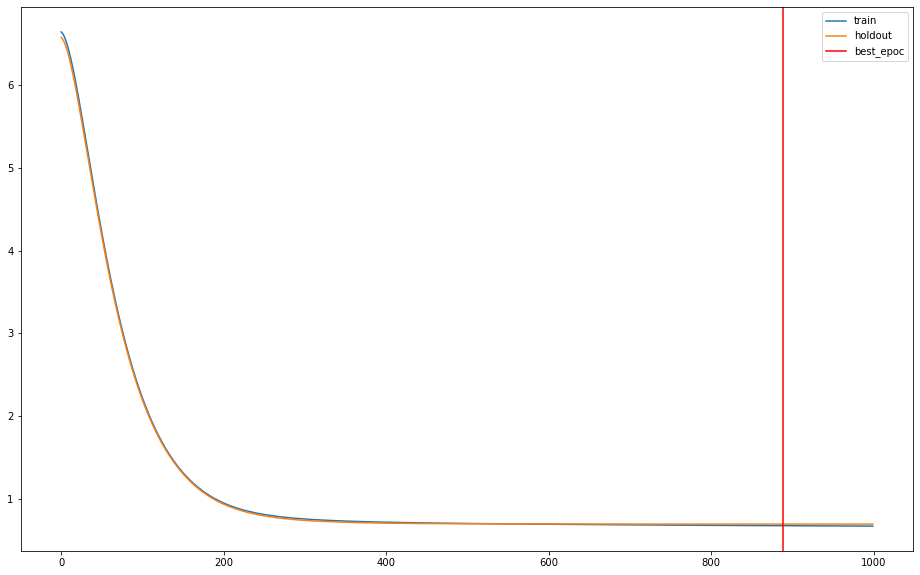

In [6]:
control.plot_losses()

In [7]:
control.clusters['learn_cluster_1'].coefs()

{'bias': tensor([-0.0187,  0.0047, -0.0125, -0.0072,  0.0099,  0.0030,  0.0178,  0.0137,
          0.0054,  0.0271,  0.0057,  0.0208, -0.0165, -0.0127, -0.0394,  0.0219,
          0.0610, -0.0243,  0.0165,  0.0077, -0.0138, -0.0313,  0.0004, -0.0024,
         -0.0088, -0.0128,  0.0081, -0.0096, -0.0260,  0.0052,  0.0216,  0.0161,
         -0.0108, -0.0195, -0.0024, -0.0196,  0.0221, -0.0015, -0.0058,  0.0114,
         -0.0134,  0.0145, -0.0078,  0.0333,  0.0274,  0.0258,  0.0132,  0.0248,
         -0.0019, -0.0282,  0.0153, -0.0291, -0.0227,  0.0103,  0.0439,  0.0010,
         -0.0066, -0.0071, -0.0035,  0.0254, -0.0186, -0.0018,  0.0252,  0.0221,
         -0.0039, -0.0308,  0.0160,  0.0276, -0.0012,  0.0146, -0.0366, -0.0001,
         -0.0303, -0.0246, -0.0076,  0.0144, -0.0290,  0.0093,  0.0049, -0.0010,
          0.0135, -0.0040,  0.0252, -0.0310, -0.0117, -0.0124, -0.0199, -0.0102,
         -0.0080,  0.0315,  0.0076,  0.0132, -0.0031, -0.0151, -0.0346, -0.0063,
         -0.0045, -0